In [12]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys,os
import pandas as pd

In [84]:
hw_path=os.path.abspath('../hw')
if hw_path not in sys.path:
    sys.path.append(hw_path)
from dvl import parse_line

In [127]:
data_file='../../data/221008-112305/viewer_data.pkl'
#data_file='../../data/221007-111613/viewer_data.pkl'
#data_file='../../data/221004-160135/viewer_data.pkl' #rope in the marina
#data_file='../../data/221006-091359/viewer_data.pkl'
#data_file='../../data/221006-094629/viewer_data.pkl'
#data_file='../../data/221007-090617/viewer_data.pkl'
#fd=open(data_file,'rb')
!ls -all -h $data_file
!ls ../../data

-rw-r--r-- 1 ori ori 42M Oct  9 05:48 ../../data/221008-112305/viewer_data.pkl
210112-112708  221005-125506  221007-090617  221007-111439  221008-104637
210302-120745  221005-131352  221007-093743  221007-111613  221008-112305
210607-182148  221006-091359  221007-100535  221008-092222  221008-113659
221004-113054  221006-094629  221007-101052  221008-095438  221008-122856
221004-113805  221006-105633  221007-101709  221008-101944  221008-130346
221004-153006  221006-105636  221007-102143  221008-102936  221008-134439
221004-160135  221007-090610  221007-105916  221008-104247


In [128]:
keys=set()
dvl_data_raw=[]
with open(data_file,'rb') as fd:
    while 1:
        try:
            d=pickle.load(fd)
            keys.add(d[0])
            if d[0]==b'topic_dvl_raw':
                dvl_data_raw.append(d[1:])
        except EOFError:
            break
print(keys)
    

{b'topic_depth_control', b'thruster_cmd', b'topic_stereo_camera_ts', b'start_time', b'topic_sonar', b'topic_att_pitch_control', b'topic_lights', b'joy_hat', b'topic_imu', b'topic_depth', b'topic_tracker', b'topic_pos_hold_pid_1', b'topic_att_roll_control', b'system_state', b'topic_hw_telem', b'topic_att_yaw_control', b'topic_hw_stats', b'topic_dvl_raw', b'joy_button', b'topic_pos_hold_pid_0'}


In [129]:
class DR(object):
    def __init__(self):
        self.last_v=None
        self.last_t=None
        self.x=0
    def __call__(self,t,v):
        if self.last_v is not None:
            va=(v+self.last_v)/2
            dt=t-self.last_t
            self.x+=va*dt
        self.last_v=v
        self.last_t=t
        return t,self.x
        

In [130]:
#parse_line(dvl_data_raw[0])
ts_vel=[]
ts_pos=[]
vel=[]
vel_valid=[]
covs=[]
foms=[]
pos=[]
tr_vels=[[],[],[],[]]
tr_dists=[[],[],[],[]]
tr_rssi=[[],[],[],[]]
tr_nsd=[[],[],[],[]]
tr_ts=[]
dr_x=[]
dr_y=[]
dr_z=[]
yaws=[]
drx=DR()
dry=DR()
drz=DR()
for d in dvl_data_raw:
    m=parse_line(d[0]['dvl_raw'])
    if m and m['type'] in ['vel']:#,'deadreacon']:
        ts_vel.append(m['tov']/1e6)
        vel.append((m['vx'],m['vy'],m['vz']))
        covs.append(m['cov'])
        foms.append(m['fom'])
        vel_valid.append(m['valid']==b'y')
        if m['valid']==b'y':
            #print(m['tov'],m['vx'])
            dr_x.append(drx(m['tov']/1e6,m['vx']))
            dr_y.append(dry(m['tov']/1e6,m['vy']))
            dr_z.append(drz(m['tov']/1e6,m['vz']))
        #print('ggg',m['valid'],m['status'])
        if m['status']>0:
            print(m)
    if m and m['type'] in ['deadreacon']:
        ts_pos.append(m['time'])
        pos.append((m['x'],m['y'],m['z']))
        yaws.append(m['yaw'])
    if m and m['type'] in ['transducer2']:
        #print(m)
        tr_vels[int(m['id'])].append(m['velocity'])
        tr_dists[int(m['id'])].append(m['distance'])
        tr_rssi[int(m['id'])].append(m['rssi'])
        tr_nsd[int(m['id'])].append(m['nsd'])
        #ts_pos.append(m['time'])
        ts=d[0]['ts']
        if m['id']==0:
            tr_ts.append(ts)
        #pos.append((m['x'],m['y'],m['z']))
    

ts_vel=np.array(ts_vel)
vel=np.array(vel)
covs=np.array(covs)
ts_pos=np.array(ts_pos)
start=ts_pos[0]
ts_pos-=start
ts_vel-=start
pos=np.array(pos)
foms=np.array(foms)
tr_vels=np.array(tr_vels).T
tr_dists=np.array(tr_dists).T
tr_rssi=np.array(tr_rssi).T
tr_nsd=np.array(tr_nsd).T
tr_ts=np.array(tr_ts)
_s=tr_ts[0]
tr_ts-=_s
dr_x=np.array(dr_x)
dr_x[:,0]-= start
dr_y=np.array(dr_y)
dr_y[:,0]-= start
dr_z=np.array(dr_z)
dr_z[:,0]-= start

In [131]:
dr_x[:,0]

array([-2.76529074e-01, -8.70850086e-02,  1.10924959e-01, ...,
        3.16773677e+02,  3.17029892e+02,  3.17284396e+02])

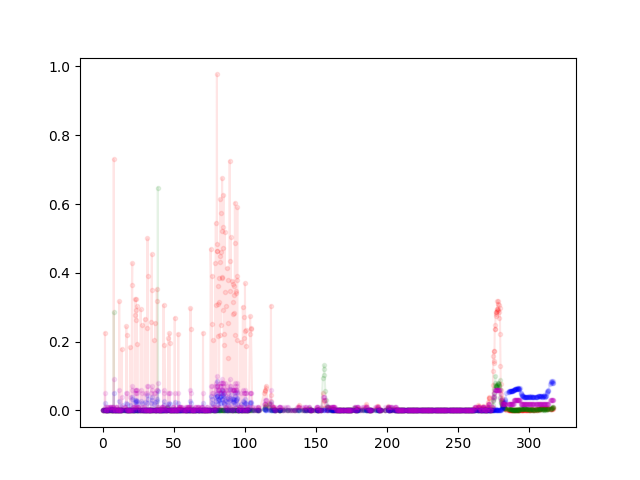

In [132]:
plt.figure()
#plt.plot(ts_vel,np.cumsum(vel[:,1]),'+-')
tresh=0.01
#inds=np.nonzero(covs[:,0+3*0]<tresh)[0]
inds=np.nonzero(vel_valid)[0]
for i in [1,2]:
    inds=np.intersect1d(inds,np.nonzero(covs[:,i+3*i]<tresh)[0])
#plt.plot(ts_vel[inds],vel[inds,:],'+-',alpha=0.4)
for i in [0,1,2]:
    #plt.plot(ts_vel[inds],vel[inds,i],'+-'+'rgb'[i],alpha=0.4)
    plt.plot(ts_vel[inds],covs[inds,i+3*i]*1e4,'.-'+'rgb'[i],alpha=0.1,)

    #plt.plot(ts_vel[inds],vel[inds,i],'+-'+'rgb'[i],alpha=0.4)
plt.plot(ts_vel[inds],foms[inds]*1e1,'.-m',alpha=0.1,)

#inds

In [133]:
dr_x[:,0]

array([-2.76529074e-01, -8.70850086e-02,  1.10924959e-01, ...,
        3.16773677e+02,  3.17029892e+02,  3.17284396e+02])

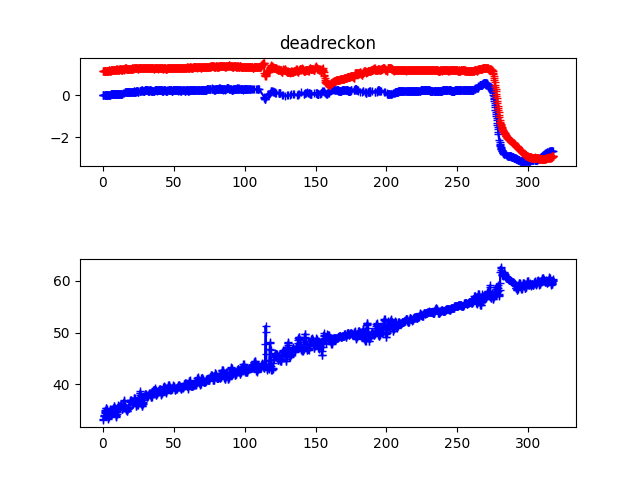

In [134]:
plt.figure()
#ind=0
ax=plt.subplot(3,1,1)
plt.title('deadreckon')
#plt.plot(ts_vel[inds][1:],np.cumsum(vel[inds][1:0,ind])*np.diff(ts_vel[inds]),'+-b')
plt.plot(dr_x[:,0],dr_x[:,1],'+-b')
#plt.plot(dr_y[:,0],-dr_y[:,1],'+-b')
#plt.plot(dr_z[:,0],dr_z[:,1],'+-b')
plt.plot(ts_pos,pos[:,ind],'+-r')
ax=plt.subplot(3,1,2,sharex=ax)
plt.plot(ts_vel[inds],vel[inds][:,ind],'+-b')
ax=plt.subplot(2,1,2,sharex=ax)
plt.plot(ts_pos,yaws,'+-b')


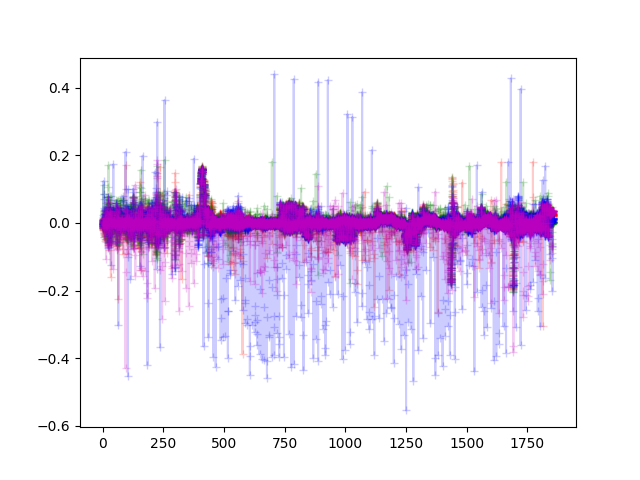

In [101]:
plt.figure()
for i in range(4):
    plt.plot(tr_ts,tr_vels[:,i],'-+'+'rgbm'[i],alpha=0.2)

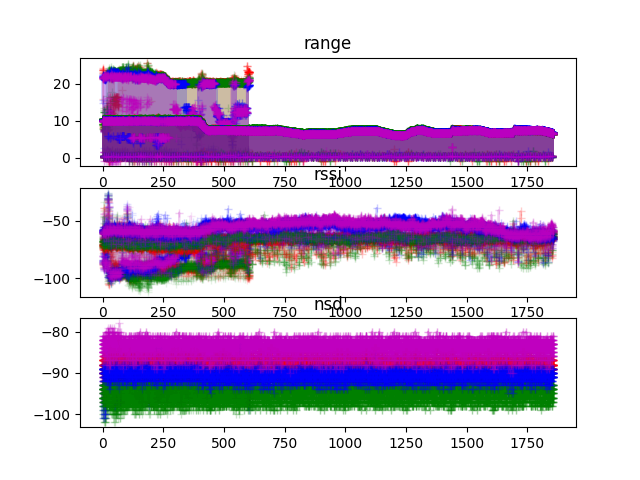

In [65]:
plt.figure('transducer')
ax=plt.subplot(3,1,1)
plt.title('range')
for i in range(4):
    plt.plot(tr_ts,tr_dists[:,i],'-+'+'rgbm'[i],alpha=0.2)
plt.subplot(3,1,2,sharex=ax)
plt.title('rssi')
for i in range(4):
    plt.plot(tr_ts,tr_rssi[:,i],'-+'+'rgbm'[i],alpha=0.1)
plt.subplot(3,1,3,sharex=ax)
plt.title('nsd')
for i in range(4):
    plt.plot(tr_ts,tr_nsd[:,i],'-+'+'rgbm'[i],alpha=0.2)
plt.show()
